MB build:   0%|          | 0/8 [00:00<?, ?it/s]

Memory bank: (5016, 1536)


Scoring normals:   0%|          | 0/8 [00:00<?, ?it/s]

Normals=8 | mean=3.8895 std=0.4635 | thr=4.8164


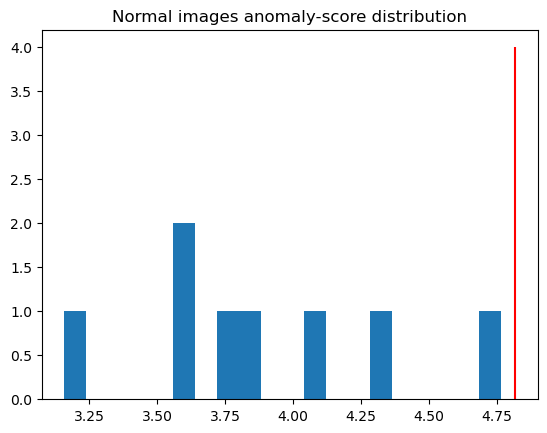

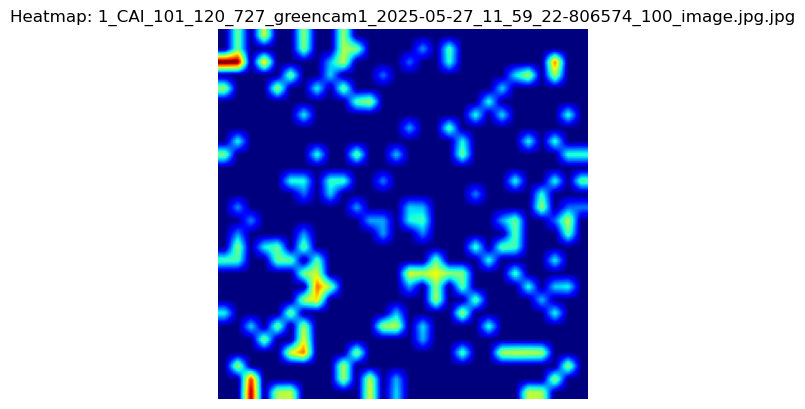

In [1]:
# ======================= STABILITY MODE (run in a fresh kernel) =======================
import os
# Limit threaded libs to avoid kernel death from MKL/OpenMP oversubscription
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

# ---- now safe to import heavy libs ----
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from sklearn.neighbors import NearestNeighbors

# Optional: also clamp PyTorch threads
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

# ----------------------- Your backbone & transform -----------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.eval()
        for p in self.model.parameters():
            p.requires_grad = False

        def hook(_, __, output):
            self.features.append(output)

        self.model.layer2[-1].register_forward_hook(hook)
        self.model.layer3[-1].register_forward_hook(hook)

    @torch.no_grad()
    def forward(self, x):
        self.features = []
        _ = self.model(x)
        avg = torch.nn.AvgPool2d(3, stride=1)
        fmap_size = self.features[0].shape[-2]
        resize = torch.nn.AdaptiveAvgPool2d(fmap_size)
        resized = [resize(avg(fm)) for fm in self.features]    # list of [B,C,H,W]
        patch = torch.cat(resized, dim=1)                      # [B,C_tot,H,W]
        patch = patch.reshape(patch.shape[0], patch.shape[1], -1).permute(0,2,1)  # [B, P, D]
        return patch.squeeze(0)  # [P, D] for B=1

# ----------------------- Config -----------------------
feat_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # only for CNN forward
mb_sample_ratio = 0.8      # 8% patches per normal image
mb_global_cap   = 15_000    # hard cap on total MB patches (tune down if needed)
nn_batch        = 5000      # query in chunks for kneighbors

# ----------------------- Init backbone -----------------------
backbone = resnet_feature_extractor().to(feat_device).eval()

@torch.no_grad()
def extract_features(img_path: Path) -> torch.Tensor:
    """Return [P,D] CPU tensor of patch features."""
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(feat_device)
    feats = backbone(x).cpu().contiguous()   # keep CPU for stability
    return feats  # [P,D]

def subsample(feats: torch.Tensor, ratio: float) -> torch.Tensor:
    P = feats.shape[0]
    k = max(1, int(P * ratio))
    idx = np.random.choice(P, size=k, replace=False)
    return feats[idx]

# ----------------------- 1) Build Memory Bank -----------------------
normal_dir = Path(r"C:\Users\nixty\non_defect_train_8")
mb_parts, total = [], 0

for pth in tqdm(list(normal_dir.iterdir()), desc="MB build", leave=False):
    F = extract_features(pth)           # [P,D] CPU
    F = subsample(F, mb_sample_ratio)   # shrink per image
    mb_parts.append(F)
    total += F.shape[0]
    if total >= mb_global_cap:
        break

memory_bank = torch.cat(mb_parts, dim=0) if mb_parts else torch.empty(0, dtype=torch.float32)
MB = memory_bank.numpy().astype(np.float32, copy=False)   # [M,D]
M, D = MB.shape if MB.size else (0, 0)
print("Memory bank:", MB.shape)

# extra safety cap
if M > mb_global_cap:
    sel = np.random.choice(M, size=mb_global_cap, replace=False)
    MB = MB[sel]
    M = MB.shape[0]
    print("MB capped to:", MB.shape)

assert M > 0, "Memory bank is empty. Check your normal folder path."

# ----------------------- 2) Fit 1-NN on MB (CPU, 1 thread) -----------------------
# n_jobs=1 prevents multithread spikes; metric='euclidean' for L2
nn = NearestNeighbors(n_neighbors=1, algorithm="auto", metric="euclidean", n_jobs=1)
nn.fit(MB)  # MB: [M,D]

# ----------------------- 3) Score normals -----------------------
def image_anomaly_score(F_t: torch.Tensor) -> float:
    F = F_t.numpy().astype(np.float32, copy=False)  # [P,D]
    P = F.shape[0]
    # Query in chunks to limit memory
    mins = np.empty((P,), dtype=np.float32)
    for s in range(0, P, nn_batch):
        e = min(P, s + nn_batch)
        dist, _ = nn.kneighbors(F[s:e], n_neighbors=1, return_distance=True)  # [p,1]
        mins[s:e] = dist[:, 0]
    return float(np.max(mins))  # image score = max per-patch NN distance

y_score = []
for pth in tqdm(list(normal_dir.iterdir()), desc="Scoring normals", leave=False):
    F = extract_features(pth)          # [P,D]
    y_score.append(image_anomaly_score(F))

y_score = np.asarray(y_score, dtype=np.float32)
thr = float(y_score.mean() + 2.0 * y_score.std())
print(f"Normals={len(y_score)} | mean={y_score.mean():.4f} std={y_score.std():.4f} | thr={thr:.4f}")

plt.figure()
plt.hist(y_score, bins=20)
plt.vlines(thr, 0, max(1, len(y_score)//2), color='r')
plt.title("Normal images anomaly-score distribution")
plt.show()

# ----------------------- 4) Optional heatmap for one image -----------------------
def per_patch_min_dists(F_t: torch.Tensor) -> np.ndarray:
    F = F_t.numpy().astype(np.float32, copy=False)  # [P,D]
    P = F.shape[0]
    mins = np.empty((P,), dtype=np.float32)
    for s in range(0, P, nn_batch):
        e = min(P, s + nn_batch)
        dist, _ = nn.kneighbors(F[s:e], n_neighbors=1, return_distance=True)
        mins[s:e] = dist[:, 0]
    return mins  # [P]

# pick one image
one_img = next(iter(normal_dir.iterdir()))
F = extract_features(one_img)
pp = per_patch_min_dists(F)
P = pp.shape[0]
side = int(np.sqrt(P))
if side * side == P:
    heat = torch.tensor(pp, dtype=torch.float32).view(1,1,side,side)
    heat_up = torch.nn.functional.interpolate(heat, size=(224,224), mode='bilinear', align_corners=False)
    plt.figure()
    plt.imshow(heat_up.squeeze().numpy(), cmap='jet')
    plt.title(f"Heatmap: {one_img.name}")
    plt.axis('off')
    plt.show()
else:
    print(f"Patch grid {P} not square; skipping heatmap.")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

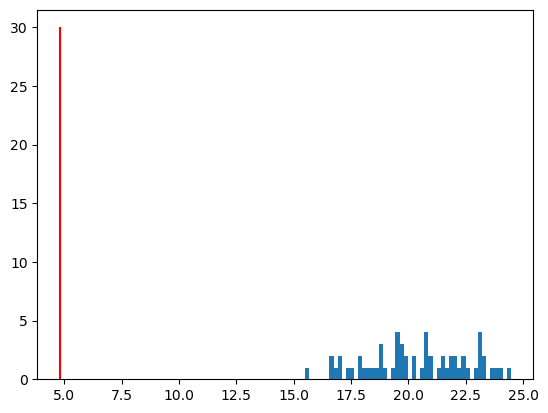

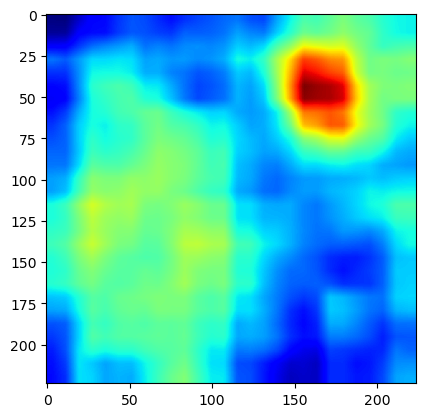

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

y_score = []
y_true = []

for classes in ['hole', 'lycra_cut', 'needln', 'twoply']:
    folder_path = Path(r'C:\Users\nixty\PatchCore_Test\Defect_Aug_2\{}'.format(classes))#"C:\Users\nixty\PatchCore_Test\Defect_Aug_2"

    for pth in tqdm(folder_path.iterdir(), leave=False):

        class_label = pth.parts[-2]

        with torch.no_grad():
            test_image = transform(Image.open(pth)).unsqueeze(0).to(device)
            features = backbone(test_image).cpu()   # keep features on CPU to avoid GPU memory crash

        distances = torch.cdist(features, memory_bank.cpu(), p=2.0)  # both on CPU
        dist_score, _ = torch.min(distances, dim=1) 
        s_star = torch.max(dist_score)
        segm_map = dist_score.view(1, 1, 28, 28) 

        y_score.append(float(s_star))  # ensure scalar
        y_true.append(0 if class_label == 'good' else 1)

# plotting only defect (non-good) scores
y_score_nok = [score for score, true in zip(y_score, y_true) if true == 1]
plt.hist(y_score_nok, bins=50)
plt.vlines(x=thr, ymin=0, ymax=30, color='r')
plt.show()


# -------- TEST ONE DEFECT IMAGE --------
test_image = transform(Image.open(r"C:\Users\nixty\defect\hole\20.jpg")).unsqueeze(0).to(device)
features = backbone(test_image).cpu()

distances = torch.cdist(features, memory_bank.cpu(), p=2.0)
dist_score, _ = torch.min(distances, dim=1) 
s_star = torch.max(dist_score)
segm_map = dist_score.view(1, 1, 28, 28)

# Upscale segmentation map to original resolution
segm_map = torch.nn.functional.interpolate(
                segm_map,
                size=(224, 224),
                mode='bilinear'
            )

plt.imshow(segm_map.squeeze(), cmap='jet')
plt.show()

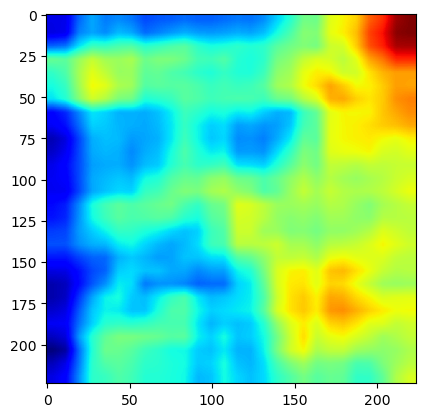

In [3]:

# -------- TEST ONE DEFECT IMAGE --------
test_image = transform(Image.open(r"C:\Users\nixty\defect\lycra_cut\86.jpg")).unsqueeze(0).to(device)
features = backbone(test_image).cpu()

distances = torch.cdist(features, memory_bank.cpu(), p=2.0)
dist_score, _ = torch.min(distances, dim=1) 
s_star = torch.max(dist_score)
segm_map = dist_score.view(1, 1, 28, 28)

# Upscale segmentation map to original resolution
segm_map = torch.nn.functional.interpolate(
                segm_map,
                size=(224, 224),
                mode='bilinear'
            )

plt.imshow(segm_map.squeeze(), cmap='jet')
plt.show()

C:\Users\nixty\PatchCore_Test\Defect_Aug_2\good


Scoring good:   0%|          | 0/40 [00:00<?, ?it/s]

C:\Users\nixty\PatchCore_Test\Defect_Aug_2\hole


Scoring hole:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\nixty\PatchCore_Test\Defect_Aug_2\lycra_cut


Scoring lycra_cut:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\nixty\PatchCore_Test\Defect_Aug_2\needln


Scoring needln:   0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\nixty\PatchCore_Test\Defect_Aug_2\twoply


Scoring twoply:   0%|          | 0/15 [00:00<?, ?it/s]

AUROC = 1.0000
Best threshold (Youden J) = 15.4793


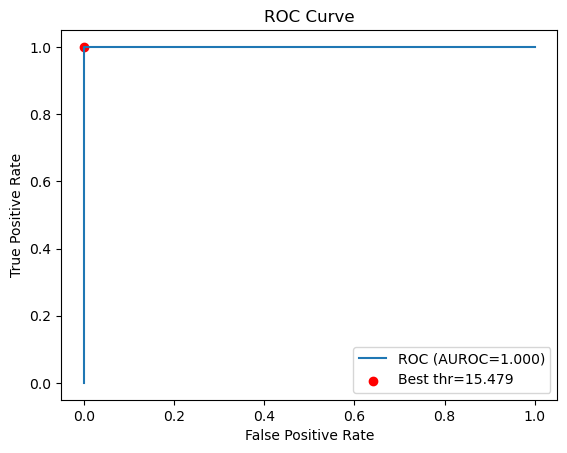

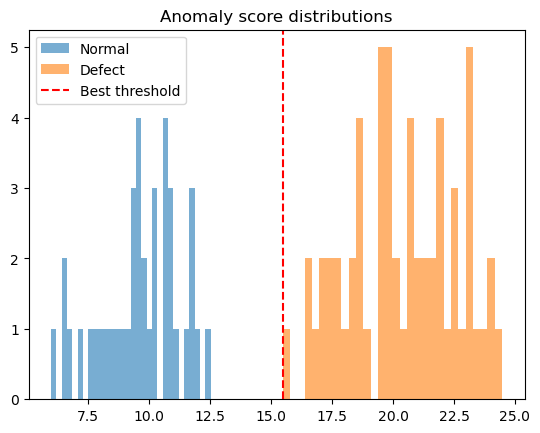

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve

# ----------------------- 5) Score test set -----------------------
y_true, y_score = [], []

# adjust this list with your defect class names
test_root = Path(r'C:\Users\nixty\PatchCore_Test\Defect_Aug_2')
classes = ["good", "hole", "lycra_cut", "needln", "twoply"]

for cls in classes:
    folder = test_root / cls
    print(folder)
    if not folder.exists():
        continue
    for pth in tqdm(list(folder.iterdir()), desc=f"Scoring {cls}", leave=False):
        F = extract_features(pth)
        score = image_anomaly_score(F)
        y_score.append(score)
        y_true.append(0 if cls == "good" else 1)

y_true = np.asarray(y_true, dtype=np.int32)
y_score = np.asarray(y_score, dtype=np.float32)

# ----------------------- 6) AUROC + best threshold -----------------------
auroc = roc_auc_score(y_true, y_score)
fpr, tpr, thr = roc_curve(y_true, y_score)

# Youden's J statistic to pick best threshold
j_scores = tpr - fpr
j_best = j_scores.argmax()
best_thr = thr[j_best]

print(f"AUROC = {auroc:.4f}")
print(f"Best threshold (Youden J) = {best_thr:.4f}")

# ----------------------- 7) ROC Curve -----------------------
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUROC={auroc:.3f})")
plt.scatter(fpr[j_best], tpr[j_best], color="red", label=f"Best thr={best_thr:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ----------------------- 8) Score distributions -----------------------
plt.figure()
plt.hist([s for s,t in zip(y_score,y_true) if t==0], bins=30, alpha=0.6, label="Normal")
plt.hist([s for s,t in zip(y_score,y_true) if t==1], bins=30, alpha=0.6, label="Defect")
plt.axvline(best_thr, color='r', linestyle='--', label="Best threshold")
plt.legend()
plt.title("Anomaly score distributions")
plt.show()


AUC-ROC Score: 1.0


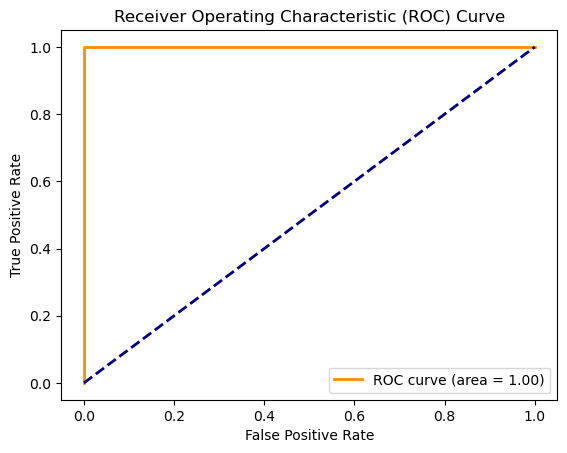

best_threshold = 15.479303359985352


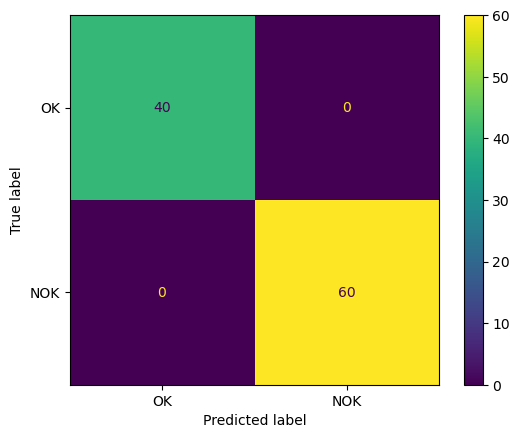

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score


# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

# Select the best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'best_threshold = {best_threshold}')

# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()

In [6]:
import joblib
import zipfile

# ---------------- Save model (NearestNeighbors + memory bank) ----------------
joblib.dump(nn, "nn_model.pkl")            # NearestNeighbors object
np.save("memory_bank.npy", MB)             # Memory bank embeddings
torch.save(backbone.state_dict(), "backbone.pth")  # ResNet backbone weights (just for reproducibility)

# ---------------- Save code & model files to ZIP ----------------
files_to_zip = [
    "nn_model.pkl",
    "memory_bank.npy",
    "backbone.pth",
    "patchcore_main.py",   # <-- your main code file (if .py script)
]

with zipfile.ZipFile("submission_patchcore.zip", "w") as zipf:
    for f in files_to_zip:
        zipf.write(f)

print("✅ submission_patchcore.zip created successfully")


FileNotFoundError: [WinError 2] The system cannot find the file specified: 'patchcore_main.py'